# Libraries that we are going to need

In [210]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display,Markdown, Image
import seaborn as sb
import plotly.express as px
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from sklearn.metrics import normalized_mutual_info_score
from sklearn.model_selection import train_test_split, KFold
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import accuracy_score, classification_report
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn import neighbors
from sklearn.feature_selection import SelectKBest, chi2, mutual_info_classif, mutual_info_regression
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# Weather-data cleaning part

## Review and Understand the Data

In [168]:
#read the weather csv to a dataframe
weather_data = pd.read_csv('weather.csv')
display(weather_data.head())
display(weather_data.info())

#check dimension {rowXcolumn}
rows, columns = weather_data.shape
values = {'Rows': [rows], 'Columns': [columns]}
data_table = pd.DataFrame(values)

display(Markdown("#### Weather data dimension"))
display(data_table)

,Date,Minimum temperature (°C),Maximum temperature (°C),Rainfall (mm),Evaporation (mm),Sunshine (hours),Direction of maximum wind gust,Speed of maximum wind gust (km/h),Time of maximum wind gust,9am Temperature (°C),...,9am cloud amount (oktas),9am wind direction,9am wind speed (km/h),9am MSL pressure (hPa),3pm Temperature (°C),3pm relative humidity (%),3pm cloud amount (oktas),3pm wind direction,3pm wind speed (km/h),3pm MSL pressure (hPa)
0,1/03/2023,14.3,21.1,3.2,2.0,4.4,SSW,28.0,10:36,14.9,...,7,W,7,1013.3,20.7,61,7,SSW,9,1013.2
1,2/03/2023,14.5,21.7,0.8,3.8,1.3,SSW,26.0,14:14,16.1,...,7,WSW,9,1014.8,21.2,59,7,SW,9,1014.3
2,3/03/2023,15.5,19.8,0.2,4.0,7.9,SSW,35.0,13:07,16.6,...,6,SE,13,1018.9,18.6,54,1,SSW,24,1017.3
3,4/03/2023,14.1,31.4,0.0,7.6,5.7,NNE,31.0,13:21,16.8,...,6,NE,7,1013.3,30.2,36,6,NNW,15,1008.0
4,5/03/2023,16.5,32.9,0.0,6.6,7.2,NNW,44.0,10:18,23.2,...,1,N,13,1003.9,29.2,31,5,SSW,6,1000.8


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 162 entries, 0 to 161
Data columns (total 21 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   Date                               162 non-null    object 
 1   Minimum temperature (°C)           162 non-null    float64
 2   Maximum temperature (°C)           162 non-null    float64
 3   Rainfall (mm)                      162 non-null    float64
 4   Evaporation (mm)                   162 non-null    float64
 5   Sunshine (hours)                   162 non-null    float64
 6   Direction of maximum wind gust     161 non-null    object 
 7   Speed of maximum wind gust (km/h)  161 non-null    float64
 8   Time of maximum wind gust          161 non-null    object 
 9   9am Temperature (°C)               162 non-null    float64
 10  9am relative humidity (%)          162 non-null    int64  
 11  9am cloud amount (oktas)           162 non-null    int64  

None

#### Weather data dimension

,Rows,Columns
0,162,21


## Clean the data

In [169]:
#Step 1.
#Data Formatting
#before we work on columns, lets change the case and replace space with underscore
weather_data.columns = weather_data.columns.str.lower().str.strip().str.replace(' ','_').str.replace('_(','(')

weather_data = weather_data.rename(columns = {"date" : "date_only", "minimum_temperature(°c)" : "min_temp", 
                                              "maximum_temperature(°c)" : "max_temp", "rainfall(mm)" : "rainfall", 
                                              "evaporation(mm)" : "evaporation", "sunshine(hours)" : "sunshine", 
                                              "direction_of_maximum_wind_gust" : "max_wind_dir", 
                                              "speed_of_maximum_wind_gust(km/h)" : "max_wind_speed", 
                                              "time_of_maximum_wind_gust" : "max_wind_time", 
                                              "9am_temperature(°c)":"9am_temp", "9am_relative_humidity(%)" : "9am_rela_humi", 
                                              "9am_cloud_amount(oktas)" : "9am_cloud", "9am_wind_direction" : "9am_wind_dir", 
                                              "9am_wind_speed(km/h)" : "9am_wind_speed", "9am_msl_pressure(hpa)" : "9am_msl_press", 
                                              "3pm_temperature(°c)" : "3pm_temp", "3pm_relative_humidity(%)" : "3pm_rela_humi", 
                                              "3pm_cloud_amount(oktas)" : "3pm_cloud", "3pm_wind_direction" : "3pm_wind_dir", 
                                              "3pm_wind_speed(km/h)" : "3pm_wind_speed", "3pm_msl_pressure(hpa)" : "3pm_msl_press"})


#lets modify data types for some of the columns
weather_data['date_only'] = pd.to_datetime(weather_data['date_only'], format='%d/%m/%Y', errors='coerce')


In [170]:
#Step 2.
#Checking for missing values
missing_values_weather = weather_data.isna().sum()
display(Markdown("#### Missing values in each column of the weather data"))
display(missing_values_weather)

# summarise how many rows and columns have missing values in weather data
total_row_missing = weather_data.isna().any(axis=1).sum()
total_column_missing = weather_data.isna().any(axis=0).sum()

display(Markdown('#### There is no missing value in price-demand data, whereas, in weather data:'))
missing_data = {'Total Rows with missing values': [total_row_missing], 
                'Total Column with missing values': [total_column_missing]}
display(pd.DataFrame(missing_data))

#### Missing values in each column of the weather data

date_only         0
min_temp          0
max_temp          0
rainfall          0
evaporation       0
sunshine          0
max_wind_dir      1
max_wind_speed    1
max_wind_time     1
9am_temp          0
9am_rela_humi     0
9am_cloud         0
9am_wind_dir      0
9am_wind_speed    0
9am_msl_press     0
3pm_temp          0
3pm_rela_humi     0
3pm_cloud         0
3pm_wind_dir      0
3pm_wind_speed    0
3pm_msl_press     0
dtype: int64

#### There is no missing value in price-demand data, whereas, in weather data:

,Total Rows with missing values,Total Column with missing values
0,1,3


In [171]:
#Step 3.
#Remove duplicates based on date_time
#No duplicates found, no rows removed
display(Markdown("#### Any duplicate in weather-data?"))
display(weather_data.duplicated().any())

#### Any duplicate in weather-data?

False

In [172]:
#Step 4.
#Deep observation in weather data
# We can observe that, wind speed at 9am and 3pm have Calm value, which is considered to be the lowest, 
#lets replace it with 0, and also, the direction of the wind is missing(white space) where speed is Calm, 
#so we will fill it with NA(Not Available) ---> Handling Noise in data

#replace "Calm" with 0 and fill empty string with NaN
weather_data = weather_data.replace('Calm', 0)
weather_data = weather_data.replace(' ',value=np.nan)
#missing value is/are of the following date:
weather_data['date_only'].values[weather_data['max_wind_dir'].isnull()].tolist()

# The value of "direction_of_maximum_wind_gust" ,"speed_of_maximum_wind_gust(km/h)" and "time_of_maximum_wind_gust" 
# on "2023-08-09" is missing.

weather_data['max_wind_dir'] = weather_data['max_wind_dir'].fillna(value=np.nan)

weather_data['max_wind_speed'] = weather_data['max_wind_speed'].fillna(0)

weather_data['max_wind_time'] = weather_data['max_wind_time'].fillna('00:00')

display(Markdown('#### After handling missing values in weather data finally we have no columns with missing value'))
display(weather_data.isna().sum())

#### After handling missing values in weather data finally we have no columns with missing value

date_only         0
min_temp          0
max_temp          0
rainfall          0
evaporation       0
sunshine          0
max_wind_dir      1
max_wind_speed    0
max_wind_time     0
9am_temp          0
9am_rela_humi     0
9am_cloud         0
9am_wind_dir      7
9am_wind_speed    0
9am_msl_press     0
3pm_temp          0
3pm_rela_humi     0
3pm_cloud         0
3pm_wind_dir      1
3pm_wind_speed    0
3pm_msl_press     0
dtype: int64

In [173]:
#Step 5.
#Checking for datatypes
display(weather_data.dtypes)

#earlier in data-formating section we couldn't change the data type of wind speed because there was a string value "Calm"
#lets modify data types for columns
weather_data[['9am_wind_speed','3pm_wind_speed']] = \
    weather_data[['9am_wind_speed','3pm_wind_speed']].astype(float)

date_only         datetime64[ns]
min_temp                 float64
max_temp                 float64
rainfall                 float64
evaporation              float64
sunshine                 float64
max_wind_dir              object
max_wind_speed           float64
max_wind_time             object
9am_temp                 float64
9am_rela_humi              int64
9am_cloud                  int64
9am_wind_dir              object
9am_wind_speed            object
9am_msl_press            float64
3pm_temp                 float64
3pm_rela_humi              int64
3pm_cloud                  int64
3pm_wind_dir              object
3pm_wind_speed            object
3pm_msl_press            float64
dtype: object

# Analysis on weather data

## Visulisation

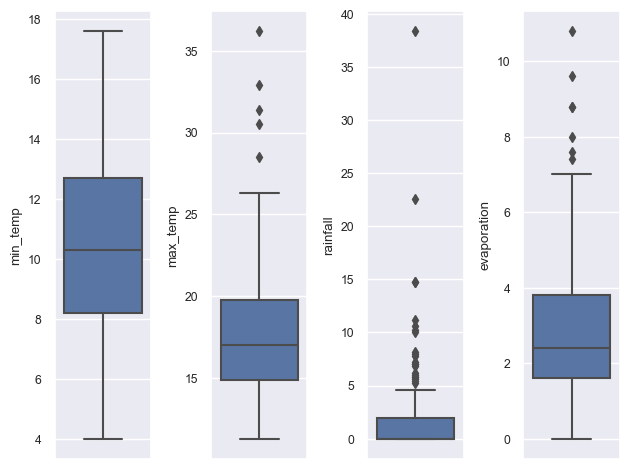

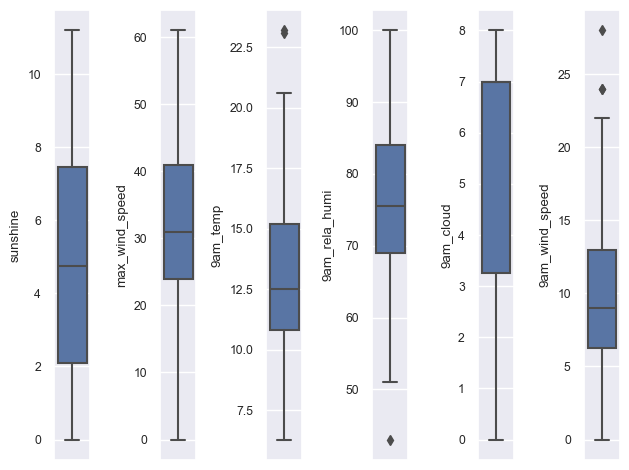

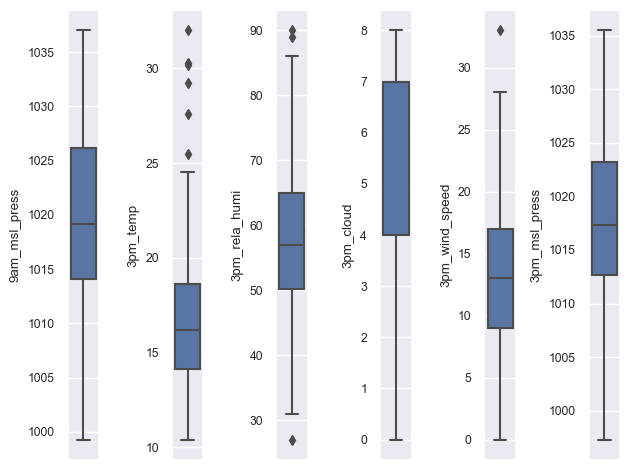

In [174]:
columns_to_plot = weather_data.iloc[:,0:5].select_dtypes(include=np.number).columns.tolist()

# Create the figure and subplots
fig, axes = plt.subplots(ncols=len(columns_to_plot))

# Create the boxplot with Seaborn
for column, axis in zip(columns_to_plot, axes):
        sb.boxplot(data=weather_data[column], ax=axis) 
        #axis.set_title(column)
        axis.set(xticklabels=[], xticks=[], ylabel=column)
        
columns_to_plot = weather_data.iloc[:,5:14].select_dtypes(include=np.number).columns.tolist()

# Show the plot
plt.tight_layout()
plt.show()

# Create the figure and subplots
fig, axes = plt.subplots(ncols=len(columns_to_plot))

# Create the boxplot with Seaborn
for column, axis in zip(columns_to_plot, axes):
        sb.boxplot(data=weather_data[column], ax=axis) 
        #axis.set_title(column)
        axis.set(xticklabels=[], xticks=[], ylabel=column)

# Show the plot
plt.tight_layout()
plt.show()
        
columns_to_plot = weather_data.iloc[:,14:].select_dtypes(include=np.number).columns.tolist()

# Create the figure and subplots
fig, axes = plt.subplots(ncols=len(columns_to_plot))

# Create the boxplot with Seaborn
for column, axis in zip(columns_to_plot, axes):
        sb.boxplot(data=weather_data[column], ax=axis) 
        #axis.set_title(column)
        axis.set(xticklabels=[], xticks=[], ylabel=column)

# Show the plot
plt.tight_layout()
plt.show()

## Statistical descriptions

In [175]:
display(weather_data.loc[:, weather_data.columns != 'date_only'].describe())

,min_temp,max_temp,rainfall,evaporation,sunshine,max_wind_speed,9am_temp,9am_rela_humi,9am_cloud,9am_wind_speed,9am_msl_press,3pm_temp,3pm_rela_humi,3pm_cloud,3pm_wind_speed,3pm_msl_press
count,162.000000,162.000000,162.000000,162.000000,162.000000,162.000000,162.000000,162.000000,162.000000,162.000000,162.000000,162.000000,162.000000,162.000000,162.000000,162.000000
mean,10.480247,17.919753,1.906173,2.861728,4.741975,32.987654,12.805556,76.395062,5.327160,9.975309,1019.666667,16.909259,58.376543,5.401235,13.259259,1017.711728
std,3.217631,4.180713,4.399727,1.923026,3.139959,11.086328,3.314138,11.394320,2.519071,5.440760,8.046264,4.043318,11.712400,2.182539,5.831544,7.825975
min,4.000000,11.300000,0.000000,0.000000,0.000000,0.000000,6.300000,43.000000,0.000000,0.000000,999.300000,10.400000,27.000000,0.000000,0.000000,997.300000
25%,8.200000,14.900000,0.000000,1.600000,2.100000,24.000000,10.825000,69.000000,3.250000,6.250000,1014.125000,14.100000,50.250000,4.000000,9.000000,1012.700000
50%,10.300000,17.050000,0.000000,2.400000,4.750000,31.000000,12.500000,75.500000,7.000000,9.000000,1019.150000,16.200000,57.000000,7.000000,13.000000,1017.300000
75%,12.700000,19.800000,1.950000,3.800000,7.475000,41.000000,15.200000,84.000000,7.000000,13.000000,1026.150000,18.600000,65.000000,7.000000,17.000000,1023.225000
max,17.600000,36.200000,38.400000,10.800000,11.200000,61.000000,23.200000,100.000000,8.000000,28.000000,1037.000000,32.000000,90.000000,8.000000,33.000000,1035.500000


In [127]:
weather_data.to_csv("clean_weather_data.csv", index=False)

# Price-demand data cleaning part

## Review and understand the data

In [176]:
demand_price_raw = pd.read_csv('PRICE_AND_DEMAND_raw_VIC1.csv')
demand_price = pd.read_csv("price_and_demand.csv")

#filter the raw data to match the same freq as the data given
demand_price_raw = demand_price_raw[demand_price_raw["SETTLEMENTDATE"].str.endswith(":00")\
                                    | demand_price_raw["SETTLEMENTDATE"].str.endswith(":30")]

#Merge
demand_price = demand_price.merge(demand_price_raw, left_on = "SETTLEMENTDATE", \
                                  right_on = "SETTLEMENTDATE", suffixes = ("_given", "_download"))

#Make sure that totaldemand from the raw data is the same as the totaldemand in the given data
#7728 raws after filtering, same as before
demand_price = demand_price[demand_price["TOTALDEMAND_given"] == demand_price["TOTALDEMAND_download"]]
demand_price = demand_price.drop(["REGION_download", "PERIODTYPE_download", "TOTALDEMAND_download"], axis=1)

#By checking the descriptive statistics of RRP
#We can see that PRICECATEGORY was generated from RRP based on its 25%, 50%% and 75% percentiles.
#RRP seems to be meaningfull, hence will be kept in the dataset for future analysis.

lst = ["EXTREME", "HIGH", "MEDIUM", "LOW"]
display(demand_price.groupby("PRICECATEGORY")["RRP"].describe().loc[lst])

display(demand_price[['TOTALDEMAND_given','RRP']].describe())

display(demand_price.head(10))
display(demand_price.info())

,count,mean,std,min,25%,50%,75%,max
PRICECATEGORY,,,,,,,,
EXTREME,1932.0,192.002505,120.096187,120.00,138.3925,157.725,232.7300,3944.97
HIGH,1932.0,93.909048,12.575269,74.33,82.7250,91.085,103.4725,120.00
MEDIUM,1932.0,38.972402,21.814998,8.94,19.1100,37.090,58.8250,74.30
LOW,1932.0,-21.597857,32.295489,-981.82,-44.0000,-19.990,0.2325,8.94


,TOTALDEMAND_given,RRP
count,7728.000000,7728.000000
mean,4935.785383,75.821524
std,931.902471,100.958703
min,2517.020000,-981.820000
25%,4203.935000,8.940000
50%,4825.085000,74.315000
75%,5541.562500,120.000000
max,7935.270000,3944.970000


,REGION_given,SETTLEMENTDATE,TOTALDEMAND_given,PERIODTYPE_given,PRICECATEGORY,RRP
0,VIC1,1/03/2023 0:30,4357.52,TRADE,HIGH,80.69
1,VIC1,1/03/2023 1:00,4234.29,TRADE,MEDIUM,63.78
2,VIC1,1/03/2023 1:30,4151.04,TRADE,MEDIUM,51.29
3,VIC1,1/03/2023 2:00,4053.40,TRADE,MEDIUM,62.39
4,VIC1,1/03/2023 2:30,3996.64,TRADE,MEDIUM,57.05
5,VIC1,1/03/2023 3:00,3950.49,TRADE,MEDIUM,49.06
6,VIC1,1/03/2023 3:30,4012.30,TRADE,MEDIUM,57.73
7,VIC1,1/03/2023 4:00,4004.10,TRADE,MEDIUM,70.00
8,VIC1,1/03/2023 4:30,4178.59,TRADE,HIGH,84.43
9,VIC1,1/03/2023 5:00,4333.45,TRADE,HIGH,102.74


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7728 entries, 0 to 7727
Data columns (total 6 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   REGION_given       7728 non-null   object 
 1   SETTLEMENTDATE     7728 non-null   object 
 2   TOTALDEMAND_given  7728 non-null   float64
 3   PERIODTYPE_given   7728 non-null   object 
 4   PRICECATEGORY      7728 non-null   object 
 5   RRP                7728 non-null   float64
dtypes: float64(2), object(4)
memory usage: 362.4+ KB


None

## Clean the data

In [177]:
#Step 1.
#data formatting
demand_price["date_time"] = pd.to_datetime(demand_price["SETTLEMENTDATE"], format='%d/%m/%Y %H:%M')
demand_price["date_only"] = pd.to_datetime(demand_price['date_time'].dt.date)
demand_price["time_only"] = demand_price['date_time'].dt.time

#Step 2.
#Drop variable with constant (meaningless) values
demand_price = demand_price.drop(["SETTLEMENTDATE", "REGION_given", "PERIODTYPE_given"], axis=1)

#Step 3. 
#Rename variables to lowercase
demand_price = demand_price.rename(columns = {"TOTALDEMAND_given": "total_demand", "PRICECATEGORY": "price_category", "RRP": "rrp"})
demand_price = demand_price[["date_time", "date_only", "time_only", "total_demand", "price_category", "rrp"]]

#Step 4.
#Remove duplicates based on date_time
#No duplicates found, no rows removed
demand_price = demand_price.drop_duplicates(subset=['date_time'])

#Step 5.
#Checking for missing values
#No missing values found
missing_values = demand_price.isnull().values.any()
print("Any missing values:", missing_values)

#Step 6.
#Capitalize all values in price_category
#Only 4 unique values (all capitalized) in the dataset
#No need to make any changes
print("Unique values for Price Category:", demand_price["price_category"].unique())

Any missing values: False
Unique values for Price Category: ['HIGH' 'MEDIUM' 'EXTREME' 'LOW']


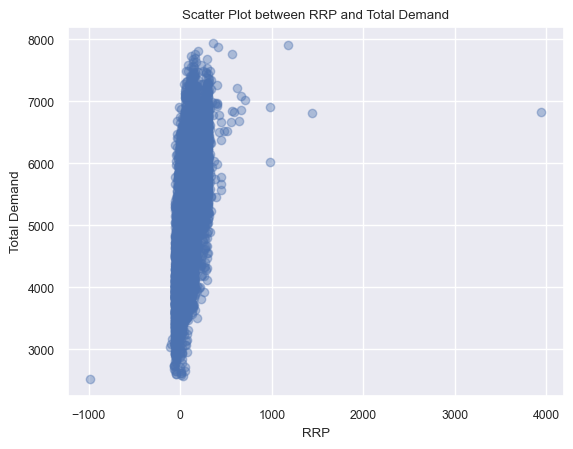

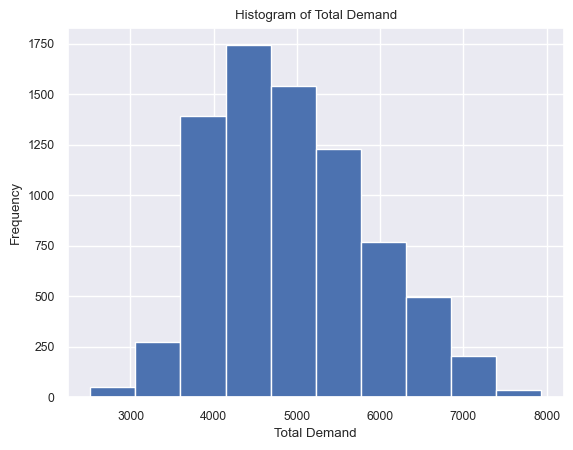

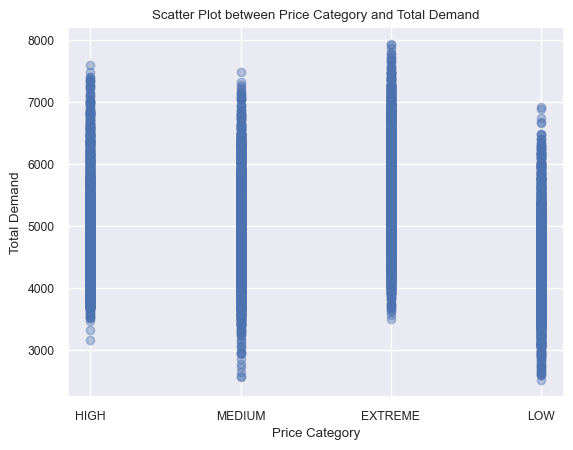

In [130]:
#Step 7.
#Outliers
plt.scatter(x=demand_price['rrp'], y=demand_price['total_demand'], alpha=0.4)
plt.title("Scatter Plot between RRP and Total Demand")
plt.xlabel("RRP")
plt.ylabel("Total Demand")
plt.show()

plt.hist(demand_price["total_demand"])
plt.title("Histogram of Total Demand")
plt.xlabel("Total Demand")
plt.ylabel("Frequency")
plt.show()

plt.scatter(x=demand_price['price_category'], y=demand_price['total_demand'], alpha=0.4)
plt.title("Scatter Plot between Price Category and Total Demand")
plt.xlabel("Price Category")
plt.ylabel("Total Demand")
plt.show()

## Create additional variables

In [178]:
#Determine price_category and total demand for a given day, 
#we have worked out: 
#average RRP among maximum price category, then convert it to the corresponding price category
#average total demand among the maximum price category

#We have also worked out the average total demand of a day for the analysis
#of relationship between total demand and weather features

rrp_25pt = demand_price["rrp"].quantile(0.25)
rrp_50pt = demand_price["rrp"].quantile(0.50)
rrp_75pt = demand_price["rrp"].quantile(0.75)

# average total demand of a day
demand_price["demand_daily_average"] = demand_price.groupby("date_only")["total_demand"].transform("mean")

# max of average demand by category VS max of average rrp by category
demand_price["temp"] = demand_price.groupby(["date_only","price_category"])["total_demand"].transform("mean")
demand_price["demand_max_cat_average"] = demand_price.groupby("date_only")["temp"].transform("max")
demand_price = demand_price.drop(["temp"], axis=1)
demand_price["temp"] = demand_price.groupby(["date_only","price_category"])["rrp"].transform("mean")
demand_price["rrp_max_cat_average"] = demand_price.groupby("date_only")["temp"].transform("max")
demand_price = demand_price.drop(["temp"], axis=1)
demand_price["price_cat_daily_max"] = ["LOW" if rrp_max <= rrp_25pt \
                                                else "MEDIUM" if rrp_max <= rrp_50pt \
                                                else "HIGH" if rrp_max <= rrp_75pt \
                                                else "EXTREME" for rrp_max in \
                                                demand_price["rrp_max_cat_average"]]
#Converting categorical variable to numerical
demand_price["price_cat_daily_max_n"] = [0 if price_cat == "LOW" \
                                              else 1 if price_cat == "MEDIUM" \
                                              else 2 if price_cat == "HIGH" \
                                              else 3 \
                                              for price_cat in demand_price["price_cat_daily_max"]]

In [179]:
demand_price.head(10)

,date_time,date_only,time_only,total_demand,price_category,rrp,demand_daily_average,demand_max_cat_average,rrp_max_cat_average,price_cat_daily_max,price_cat_daily_max_n
0,2023-03-01 00:30:00,2023-03-01,00:30:00,4357.52,HIGH,80.69,4487.52,5047.5325,136.5675,EXTREME,3
1,2023-03-01 01:00:00,2023-03-01,01:00:00,4234.29,MEDIUM,63.78,4487.52,5047.5325,136.5675,EXTREME,3
2,2023-03-01 01:30:00,2023-03-01,01:30:00,4151.04,MEDIUM,51.29,4487.52,5047.5325,136.5675,EXTREME,3
3,2023-03-01 02:00:00,2023-03-01,02:00:00,4053.40,MEDIUM,62.39,4487.52,5047.5325,136.5675,EXTREME,3
4,2023-03-01 02:30:00,2023-03-01,02:30:00,3996.64,MEDIUM,57.05,4487.52,5047.5325,136.5675,EXTREME,3
5,2023-03-01 03:00:00,2023-03-01,03:00:00,3950.49,MEDIUM,49.06,4487.52,5047.5325,136.5675,EXTREME,3
6,2023-03-01 03:30:00,2023-03-01,03:30:00,4012.30,MEDIUM,57.73,4487.52,5047.5325,136.5675,EXTREME,3
7,2023-03-01 04:00:00,2023-03-01,04:00:00,4004.10,MEDIUM,70.00,4487.52,5047.5325,136.5675,EXTREME,3
8,2023-03-01 04:30:00,2023-03-01,04:30:00,4178.59,HIGH,84.43,4487.52,5047.5325,136.5675,EXTREME,3
9,2023-03-01 05:00:00,2023-03-01,05:00:00,4333.45,HIGH,102.74,4487.52,5047.5325,136.5675,EXTREME,3


In [133]:
demand_price.to_csv("clean_demand_price.csv", index=False)

# Merging 2 datasets

In [180]:
display(Markdown('#### Cleaned Weather Data'))
display(weather_data)

display(Markdown('#### Cleaned Energy Data'))
display(demand_price)

#### Cleaned Weather Data

,date_only,min_temp,max_temp,rainfall,evaporation,sunshine,max_wind_dir,max_wind_speed,max_wind_time,9am_temp,...,9am_cloud,9am_wind_dir,9am_wind_speed,9am_msl_press,3pm_temp,3pm_rela_humi,3pm_cloud,3pm_wind_dir,3pm_wind_speed,3pm_msl_press
0,2023-03-01,14.3,21.1,3.2,2.0,4.4,SSW,28.0,10:36,14.9,...,7,W,7.0,1013.3,20.7,61,7,SSW,9.0,1013.2
1,2023-03-02,14.5,21.7,0.8,3.8,1.3,SSW,26.0,14:14,16.1,...,7,WSW,9.0,1014.8,21.2,59,7,SW,9.0,1014.3
2,2023-03-03,15.5,19.8,0.2,4.0,7.9,SSW,35.0,13:07,16.6,...,6,SE,13.0,1018.9,18.6,54,1,SSW,24.0,1017.3
3,2023-03-04,14.1,31.4,0.0,7.6,5.7,NNE,31.0,13:21,16.8,...,6,NE,7.0,1013.3,30.2,36,6,NNW,15.0,1008.0
4,2023-03-05,16.5,32.9,0.0,6.6,7.2,NNW,44.0,10:18,23.2,...,1,N,13.0,1003.9,29.2,31,5,SSW,6.0,1000.8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
157,2023-08-05,9.3,13.6,0.0,2.8,3.0,SSW,26.0,10:45,11.0,...,7,SW,9.0,1033.5,13.0,57,7,SW,7.0,1033.5
158,2023-08-06,8.6,13.4,0.0,0.6,0.8,S,20.0,13:12,9.9,...,8,WNW,4.0,1035.4,12.2,77,7,SSW,11.0,1033.6
159,2023-08-07,9.0,13.7,0.0,1.4,2.6,SW,19.0,13:06,10.6,...,7,NaN,0.0,1033.8,13.3,63,7,SSW,11.0,1032.2
160,2023-08-08,4.7,14.2,0.0,1.0,7.3,SSW,15.0,13:52,6.3,...,7,NE,7.0,1034.0,13.3,67,1,SSW,9.0,1030.3


#### Cleaned Energy Data

,date_time,date_only,time_only,total_demand,price_category,rrp,demand_daily_average,demand_max_cat_average,rrp_max_cat_average,price_cat_daily_max,price_cat_daily_max_n
0,2023-03-01 00:30:00,2023-03-01,00:30:00,4357.52,HIGH,80.69,4487.52000,5047.532500,136.567500,EXTREME,3
1,2023-03-01 01:00:00,2023-03-01,01:00:00,4234.29,MEDIUM,63.78,4487.52000,5047.532500,136.567500,EXTREME,3
2,2023-03-01 01:30:00,2023-03-01,01:30:00,4151.04,MEDIUM,51.29,4487.52000,5047.532500,136.567500,EXTREME,3
3,2023-03-01 02:00:00,2023-03-01,02:00:00,4053.40,MEDIUM,62.39,4487.52000,5047.532500,136.567500,EXTREME,3
4,2023-03-01 02:30:00,2023-03-01,02:30:00,3996.64,MEDIUM,57.05,4487.52000,5047.532500,136.567500,EXTREME,3
...,...,...,...,...,...,...,...,...,...,...,...
7723,2023-08-08 22:00:00,2023-08-08,22:00:00,5797.87,HIGH,82.84,5562.29875,6505.416154,275.063846,EXTREME,3
7724,2023-08-08 22:30:00,2023-08-08,22:30:00,5562.07,HIGH,81.21,5562.29875,6505.416154,275.063846,EXTREME,3
7725,2023-08-08 23:00:00,2023-08-08,23:00:00,5321.93,MEDIUM,54.97,5562.29875,6505.416154,275.063846,EXTREME,3
7726,2023-08-08 23:30:00,2023-08-08,23:30:00,5315.61,MEDIUM,54.97,5562.29875,6505.416154,275.063846,EXTREME,3


In [181]:
merged_data = pd.merge(demand_price, weather_data,on='date_only', how='left')
merged_data["date_only"] = pd.to_datetime(merged_data['date_only'])
merged_data["month"] = pd.DatetimeIndex(merged_data["date_only"]).month

merged_data.to_csv("merged_data.csv", index=False)

In [182]:
#keep 1 obervation for a particular day
merged_data_daily = merged_data.drop_duplicates(subset=['date_only'])
merged_data_daily = merged_data_daily.drop(["date_time", "time_only", "total_demand", "rrp", "price_category"], axis=1)

#get the weekday, value ranging from 0 to 6, representing Monday to Sunday
merged_data_daily["weekday"] = merged_data_daily["date_only"].dt.weekday

#getting either weekday is week-end(1) or week-day(0)
merged_data_daily["type_of_day_n"] = [1 if weekday < 5 \
                                      else 0 \
                                      for weekday in merged_data_daily["weekday"]]

merged_data_daily["type_of_day_s"] = ["weekday" if weekday < 5 \
                                      else "weekend" \
                                      for weekday in merged_data_daily["weekday"]]

merged_data_daily["max_wind_dir_n"] = merged_data_daily['max_wind_dir'].replace(['SSW', 'NNE', 'NNW', 'NW', 'W', 'SSE', 'S', 'WSW', 'N', 'ESE', 'WNW', 'SW', 'E', 'SE', 'NE'],\
                                                      [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14])
merged_data_daily['9am_wind_dir_n'] = merged_data_daily['9am_wind_dir'].replace(['W', 'WSW', 'SE', 'NE', 'N', 'NW', 'NNW', 'WNW', 'SSE', 'S', 'NNE', 'SSW', 'ESE', 'SW', 'E'],
                                                      [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14])
merged_data_daily['3pm_wind_dir_n'] = merged_data_daily['3pm_wind_dir'].replace(['SSW', 'SW', 'NNW', 'NW', 'W', 'S', 'N', 'WSW', 'NE', 'E', 'SSE', 'SE', 'WNW', 'NNE'],
                                                      [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13])


In [137]:
merged_data_daily.head()

,date_only,demand_daily_average,demand_max_cat_average,rrp_max_cat_average,price_cat_daily_max,price_cat_daily_max_n,min_temp,max_temp,rainfall,evaporation,...,3pm_wind_dir,3pm_wind_speed,3pm_msl_press,month,weekday,type_of_day_n,type_of_day_s,max_wind_dir_n,9am_wind_dir_n,3pm_wind_dir_n
0,2023-03-01,4487.520000,5047.532500,136.567500,EXTREME,3,14.3,21.1,3.2,2.0,...,SSW,9.0,1013.2,3,2,1,weekday,0.0,0.0,0.0
47,2023-03-02,4710.521667,5209.111429,136.411429,EXTREME,3,14.5,21.7,0.8,3.8,...,SW,9.0,1014.3,3,3,1,weekday,0.0,1.0,1.0
95,2023-03-03,4246.886250,5139.640000,128.670000,EXTREME,3,15.5,19.8,0.2,4.0,...,SSW,24.0,1017.3,3,4,1,weekday,0.0,2.0,0.0
143,2023-03-04,4403.416042,5349.027143,146.182857,EXTREME,3,14.1,31.4,0.0,7.6,...,NNW,15.0,1008.0,3,5,0,weekend,1.0,3.0,2.0
191,2023-03-05,4374.926458,5907.100000,132.210000,EXTREME,3,16.5,32.9,0.0,6.6,...,SSW,6.0,1000.8,3,6,0,weekend,2.0,4.0,0.0


# Initial Analysis of Merged Data

# 1. Correlation & NMI

In [183]:
merged_data_daily.info()

<class 'pandas.core.frame.DataFrame'>
Index: 162 entries, 0 to 7727
Data columns (total 33 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   date_only               162 non-null    datetime64[ns]
 1   demand_daily_average    162 non-null    float64       
 2   demand_max_cat_average  162 non-null    float64       
 3   rrp_max_cat_average     162 non-null    float64       
 4   price_cat_daily_max     162 non-null    object        
 5   price_cat_daily_max_n   162 non-null    int64         
 6   min_temp                162 non-null    float64       
 7   max_temp                162 non-null    float64       
 8   rainfall                162 non-null    float64       
 9   evaporation             162 non-null    float64       
 10  sunshine                162 non-null    float64       
 11  max_wind_dir            161 non-null    object        
 12  max_wind_speed          162 non-null    float64       

Text(0.5, 1.0, 'Correlation Matrix (Pearson r) between Numerical Variables')

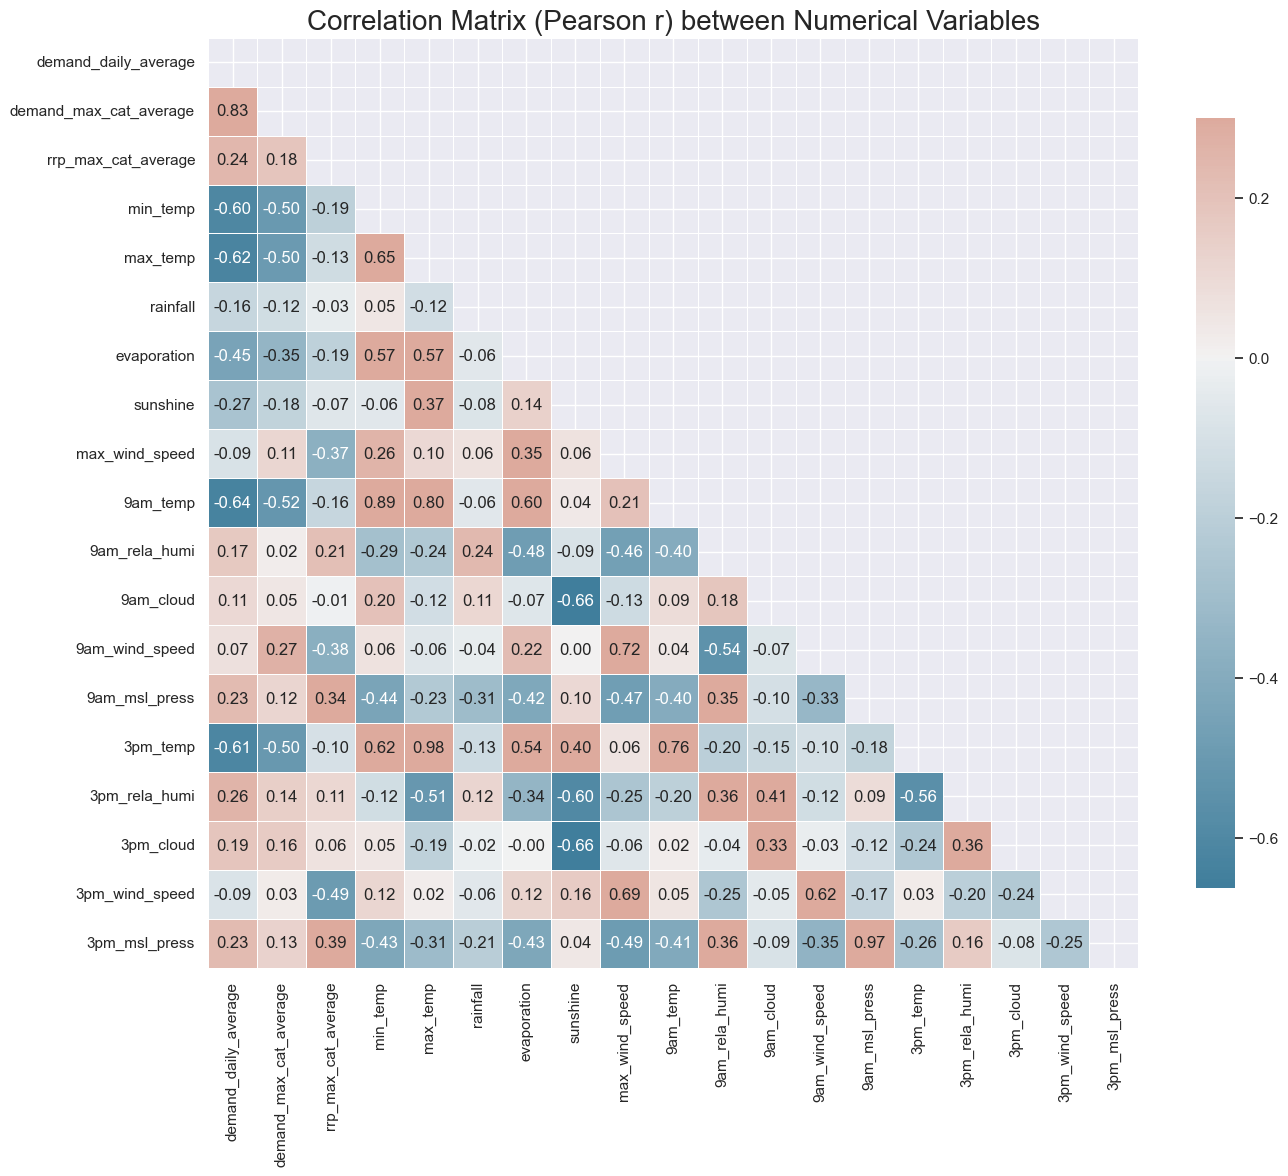

In [185]:
#Analysing correlation between variables

corr = merged_data_daily.drop(["price_cat_daily_max_n", "month", "weekday", "type_of_day_n", 
                               "max_wind_dir_n", "9am_wind_dir_n", "3pm_wind_dir_n"], axis=1).corr(method='pearson', numeric_only = True)
mask = np.triu(np.ones_like(corr, dtype=bool))
f, ax = plt.subplots(figsize=(15, 20))
cmap = sb.diverging_palette(230, 20, as_cmap=True)
sb.set(font_scale=1)
sb.heatmap(corr, annot = True, mask=mask, cmap=cmap, vmax=.3, center=0,
           fmt=".2f", square=True, linewidths=.5, cbar_kws={"shrink": .5})
plt.title('Correlation Matrix (Pearson r) between Numerical Variables', fontsize = 20)

In [140]:
# Identify correlations with absolute value higher than 0.6
# Excluding those variables in the model
corr_matrix = corr.abs()
sol = (corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
                  .stack()
                  .sort_values(ascending=False))
cor_dic={}
for index, value in sol.items():
    value = round(value,2)
    if value > 0.6:
        if index[0] in cor_dic:
            cor_dic[index[0]][index[1]] = value
        elif index[1] in cor_dic:
            cor_dic[index[1]][index[0]] = value
        else:
            cor_dic[index[0]] = {index[1]:value}

for index, value in cor_dic.items():
    print("Feature 1:", index)
    print("Features 2:", value)
    print("*****************************************************************")


#by checking the correlation matrix, the following features will be excluded from the model
'''max_temp
9am_msl_press
demand_daily_average
3pm_temp
max_wind_speed
sunshine
9am_wind_speed
9am_temp
'''

Feature 1: max_temp
Features 2: {'3pm_temp': 0.98, '9am_temp': 0.8}
*****************************************************************
Feature 1: 9am_msl_press
Features 2: {'3pm_msl_press': 0.97}
*****************************************************************
Feature 1: min_temp
Features 2: {'9am_temp': 0.89, 'max_temp': 0.65, '3pm_temp': 0.62}
*****************************************************************
Feature 1: demand_daily_average
Features 2: {'demand_max_cat_average': 0.83, '9am_temp': 0.64, 'max_temp': 0.62, '3pm_temp': 0.61}
*****************************************************************
Feature 1: 9am_temp
Features 2: {'3pm_temp': 0.76}
*****************************************************************
Feature 1: max_wind_speed
Features 2: {'9am_wind_speed': 0.72, '3pm_wind_speed': 0.69}
*****************************************************************
Feature 1: sunshine
Features 2: {'9am_cloud': 0.66, '3pm_cloud': 0.66}
************************************************

'max_temp\n9am_msl_press\ndemand_daily_average\n3pm_temp\nmax_wind_speed\nsunshine\n9am_wind_speed\n9am_temp\n'

In [141]:
#checking for features with inter-correlation of >0.6 or <-0.6 after removing features identified

corr = merged_data_daily.drop(["price_cat_daily_max_n", "month", "weekday", "type_of_day_n", 
                               "max_wind_dir_n", "9am_wind_dir_n", "3pm_wind_dir_n",
                               "max_temp", "9am_msl_press", "demand_daily_average", "3pm_temp",
                               "max_wind_speed", "sunshine", "9am_wind_speed", "9am_temp"], 
                              axis=1).corr(method='pearson', numeric_only = True)

corr_matrix = corr.abs()
sol = (corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
                  .stack()
                  .sort_values(ascending=False))
cor_dic={}
for index, value in sol.items():
    value = round(value,2)
    if value > 0.6:
        if index[0] in cor_dic:
            cor_dic[index[0]][index[1]] = value
        elif index[1] in cor_dic:
            cor_dic[index[1]][index[0]] = value
        else:
            cor_dic[index[0]] = {index[1]:value}

for index, value in cor_dic.items():
    print("Feature 1:", index)
    print("Features 2:", value)
    print("*****************************************************************")

if not cor_dic:
    print("No more features with inter-correlation of more than 0.6 or less than -0.6!")

No more features with inter-correlation of more than 0.6 or less than -0.6!


Text(0.5, 1.0, 'NMI between Categorical Variables')

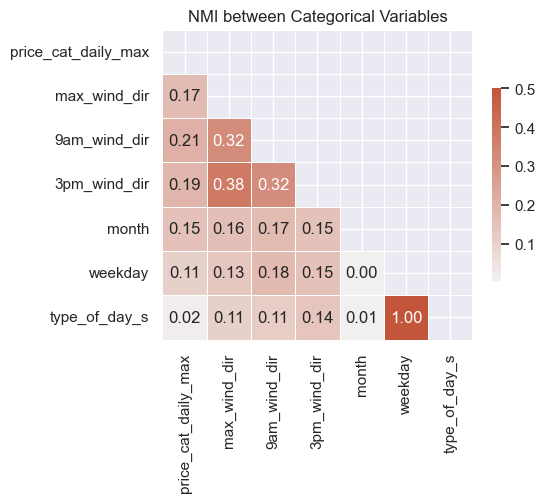

In [142]:
#Analysing NMI between categorical variables
#NMI => [0, 1]
# < 0.2: non-existent
# 0.2 - 0.4: moderate
# 0.5 - 0.7: strong
# 0.8 - 1.0: very strong

#All variables are not related to each other,
#Except for 

categorical_variables = ["price_cat_daily_max", "max_wind_dir", "9am_wind_dir", "3pm_wind_dir", "month", "weekday","type_of_day_s"]

nmi_matrix = {}

for cat_1 in categorical_variables:
    nmi_row = []
    for cat_2 in categorical_variables:
        temp_data = merged_data_daily.dropna(subset=[cat_1])
        temp_data = temp_data.dropna(subset=[cat_2])
        NMI = normalized_mutual_info_score(temp_data[cat_1], temp_data[cat_2], average_method='min')
        nmi_row.append(NMI)
    nmi_matrix[cat_1] = nmi_row

nmi_df = pd.DataFrame(data = nmi_matrix,columns=categorical_variables, index=categorical_variables)

mask = np.triu(np.ones_like(nmi_df, dtype=bool))
f, ax = plt.subplots(figsize=(5, 10))
cmap = sb.diverging_palette(50, 20, as_cmap=True)
sb.set(font_scale=1)
ax = sb.heatmap(nmi_df, annot = True, mask=mask, cmap=cmap, vmax=.5, center=0,
           fmt=".2f", square=True, linewidths=.5, cbar_kws={"shrink": .25})
plt.title("NMI between Categorical Variables", fontsize=12)

C:\Users\zheng\anaconda3\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning:

The figure layout has changed to tight

C:\Users\zheng\anaconda3\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning:

The figure layout has changed to tight

C:\Users\zheng\anaconda3\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning:

The figure layout has changed to tight

C:\Users\zheng\anaconda3\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning:

The figure layout has changed to tight

C:\Users\zheng\anaconda3\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning:

The figure layout has changed to tight

C:\Users\zheng\anaconda3\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning:

The figure layout has changed to tight



### Scatter Plot Matrix of rrp_daily vs. features

C:\Users\zheng\AppData\Local\Temp\ipykernel_7888\3480031021.py:24: UserWarning:

The figure layout has changed to tight



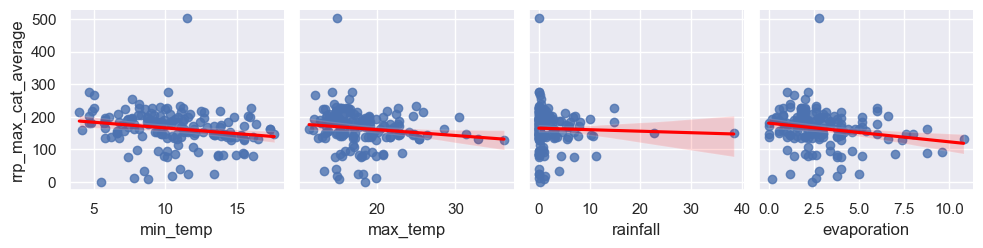

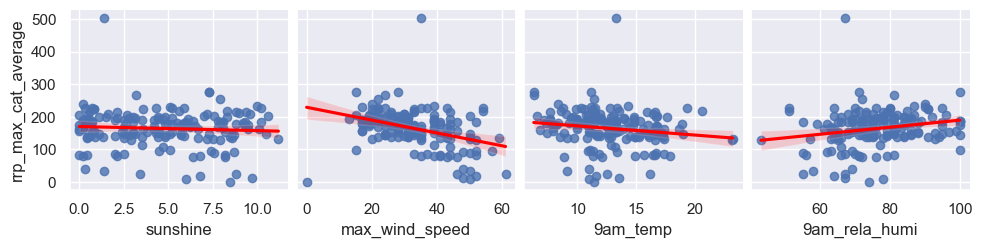

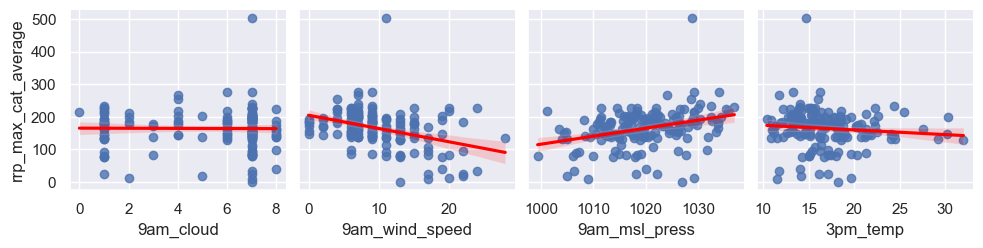

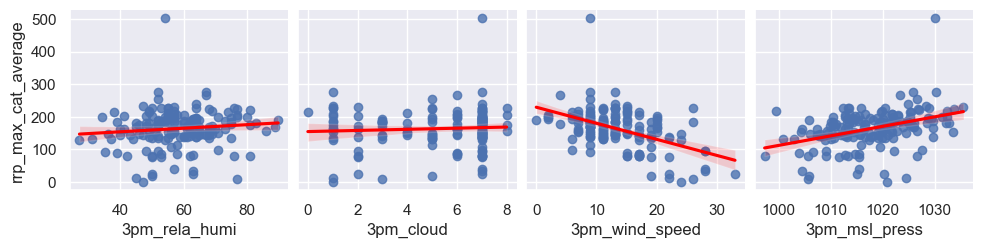

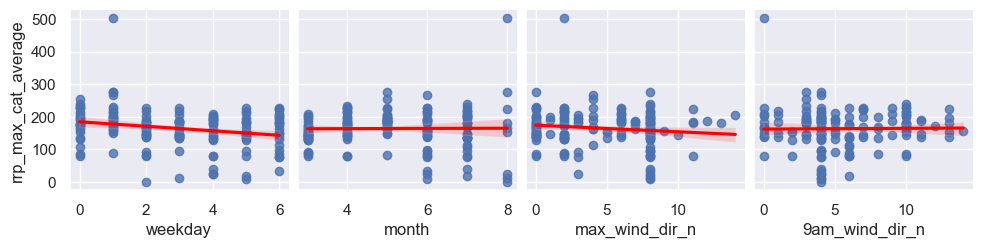

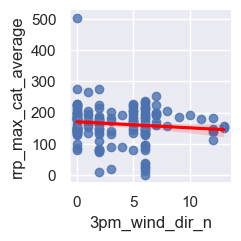

In [143]:
#Visulisation of the correlation between features and rrp
weather_features = ["min_temp", "max_temp", "rainfall", "evaporation", "sunshine", "max_wind_speed", 
                    "9am_temp", "9am_rela_humi", "9am_cloud", "9am_wind_speed", "9am_msl_press", 
                    "3pm_temp", "3pm_rela_humi", "3pm_cloud", "3pm_wind_speed", "3pm_msl_press", 
                    "weekday", "month", "max_wind_dir_n", "9am_wind_dir_n", "3pm_wind_dir_n"]

rrp_daily = ["rrp_max_cat_average"]

plot_kws = {'line_kws':{'color':'red'}}

for rrp in rrp_daily:
    sb.pairplot(merged_data_daily, kind="reg", y_vars=rrp, x_vars=weather_features[:4], plot_kws=plot_kws)
    sb.pairplot(merged_data_daily, kind="reg", y_vars=rrp, x_vars=weather_features[4:8], plot_kws=plot_kws)
    sb.pairplot(merged_data_daily, kind="reg", y_vars=rrp, x_vars=weather_features[8:12], plot_kws=plot_kws)
    sb.pairplot(merged_data_daily, kind="reg", y_vars=rrp, x_vars=weather_features[12:16], plot_kws=plot_kws)
    sb.pairplot(merged_data_daily, kind="reg", y_vars=rrp, x_vars=weather_features[16:20], plot_kws=plot_kws)    
    sb.pairplot(merged_data_daily, kind="reg", y_vars=rrp, x_vars=weather_features[20:21], plot_kws=plot_kws)     

    sb.set(font_scale=0.8)

    display(Markdown("### Scatter Plot Matrix of rrp_daily vs. features"))

    plt.grid(True)
    plt.tight_layout()
    plt.show()

C:\Users\zheng\anaconda3\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning:

The figure layout has changed to tight

C:\Users\zheng\anaconda3\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning:

The figure layout has changed to tight

C:\Users\zheng\anaconda3\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning:

The figure layout has changed to tight

C:\Users\zheng\anaconda3\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning:

The figure layout has changed to tight

C:\Users\zheng\anaconda3\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning:

The figure layout has changed to tight

C:\Users\zheng\anaconda3\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning:

The figure layout has changed to tight



### Scatter Plot Matrix of average daily demand vs. features

C:\Users\zheng\AppData\Local\Temp\ipykernel_7888\1611807114.py:25: UserWarning:

The figure layout has changed to tight



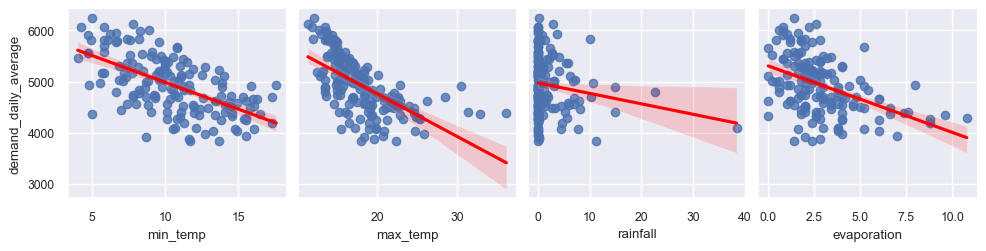

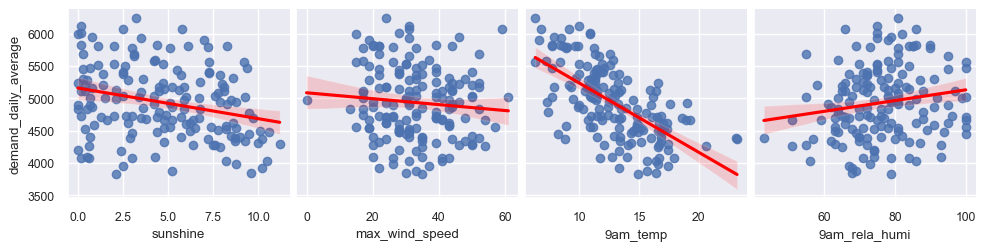

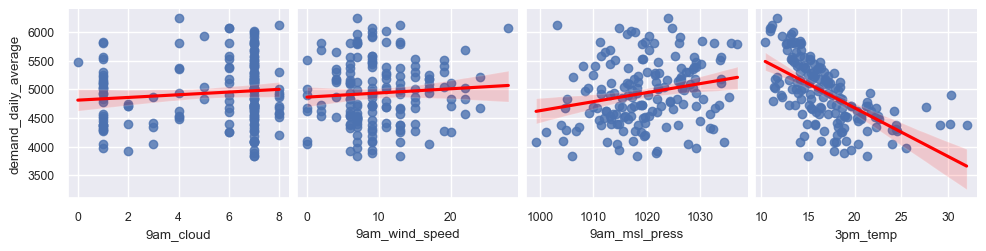

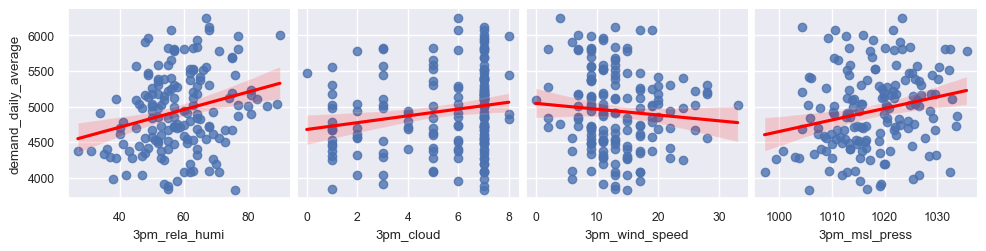

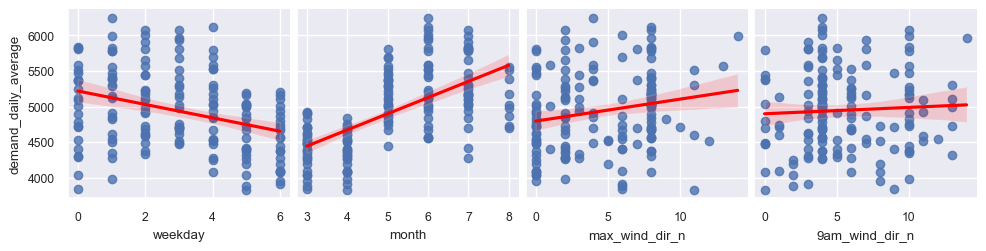

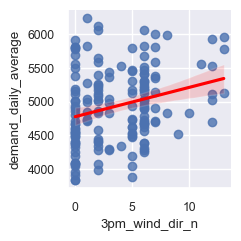

In [144]:
#Visulisation of the correlation between features and daily average demand
weather_features = ["min_temp", "max_temp", "rainfall", "evaporation", "sunshine", "max_wind_speed", 
                    "9am_temp", "9am_rela_humi", "9am_cloud", "9am_wind_speed", "9am_msl_press", 
                    "3pm_temp", "3pm_rela_humi", "3pm_cloud", "3pm_wind_speed", "3pm_msl_press", 
                    "weekday", "month", "max_wind_dir_n", "9am_wind_dir_n", "3pm_wind_dir_n"]

demand_daily = ["demand_daily_average"]

plot_kws = {'line_kws':{'color':'red'}}

for demand in demand_daily:
    #seaborn
    sb.pairplot(merged_data_daily, kind="reg", y_vars=demand, x_vars=weather_features[:4], plot_kws=plot_kws)
    sb.pairplot(merged_data_daily, kind="reg", y_vars=demand, x_vars=weather_features[4:8], plot_kws=plot_kws)
    sb.pairplot(merged_data_daily, kind="reg", y_vars=demand, x_vars=weather_features[8:12], plot_kws=plot_kws)
    sb.pairplot(merged_data_daily, kind="reg", y_vars=demand, x_vars=weather_features[12:16], plot_kws=plot_kws)
    sb.pairplot(merged_data_daily, kind="reg", y_vars=demand, x_vars=weather_features[16:20], plot_kws=plot_kws)    
    sb.pairplot(merged_data_daily, kind="reg", y_vars=demand, x_vars=weather_features[20:21], plot_kws=plot_kws)     

    sb.set(font_scale=0.8)

    display(Markdown("### Scatter Plot Matrix of average daily demand vs. features"))

    plt.grid(True)
    plt.tight_layout()
    plt.show()

In [145]:
#draw scatter plot between price and type of a day
rrp_daily = ["rrp_max_cat_average"]

for rrp in rrp_daily:
    fig1 = px.scatter(merged_data_daily, x='date_only', y=rrp, color='type_of_day_s',title='Price Vs Type of Day')
    fig1.show()

    
#draw scatter plot between demand and type of a day
demand_type = ["demand_daily_average"]

for demand in demand_type:
    fig2 = px.scatter(merged_data_daily, x='date_only', y=demand, color='type_of_day_s',title='Demand Vs Type of Day')
    fig2.show()

# Model

# Decision Tree

In [186]:
data = merged_data_daily.reset_index().drop(["index"], axis=1)

demand = ["demand_max_cat_average"] 
price_category = ["price_cat_daily_max"]


for i in range(len(demand)):
    features = ["min_temp", "rainfall", "evaporation", "9am_rela_humi", "9am_cloud", "9am_wind_dir_n",
                "3pm_rela_humi", "3pm_cloud", "3pm_wind_speed", "3pm_msl_press", "month", "weekday"]
    features.append(demand[i])
    
    x = data[features]
    y = data[price_category[i]]
    
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

    scaler = StandardScaler().fit(x_train)
    x_train = scaler.transform(x_train)
    x_test = scaler.transform(x_test)
    
    imputer = SimpleImputer(strategy='mean')
    x_train = imputer.fit_transform(x_train)
    x_test = imputer.transform(x_test)

    dt = DecisionTreeClassifier(criterion="entropy", random_state=42, max_depth=6)
    dt.fit(x_train, y_train)

    y_pred = dt.predict(x_test)

    classification_accuracy = accuracy_score(y_test, y_pred)
    print(price_category[i])
    print("DT Accuracy:", classification_accuracy)
    print("DT Report:")
    print(classification_report(y_test, y_pred))
    print("**********************************************************")
    print(" ")


price_cat_daily_max
DT Accuracy: 0.8484848484848485
DT Report:
              precision    recall  f1-score   support

     EXTREME       0.90      0.93      0.92        29
        HIGH       0.33      0.25      0.29         4

    accuracy                           0.85        33
   macro avg       0.62      0.59      0.60        33
weighted avg       0.83      0.85      0.84        33

**********************************************************
 


### Loop to choose the best max_depth

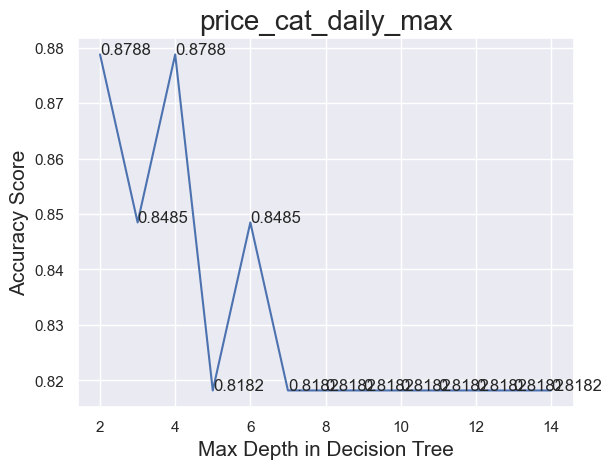

In [187]:
data = merged_data_daily.reset_index().drop(["index"], axis=1)

demand = ["demand_max_cat_average"] 
price_category = ["price_cat_daily_max"]

for i in range(len(demand)):
    accuracy_list = []
    depth_list = []
    for dt_depth in range(2,15):
        features = ["min_temp", "rainfall", "evaporation", "9am_rela_humi", "9am_cloud", "9am_wind_dir_n",
                    "3pm_rela_humi", "3pm_cloud", "3pm_wind_speed", "3pm_msl_press", "month", "weekday"]
        features.append(demand[i])
    
        x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

        scaler = StandardScaler().fit(x_train)
        x_train = scaler.transform(x_train)
        x_test = scaler.transform(x_test)
    
        imputer = SimpleImputer(strategy='mean')
        x_train = imputer.fit_transform(x_train)
        x_test = imputer.transform(x_test)

        dt = DecisionTreeClassifier(criterion="entropy", random_state=42, max_depth=dt_depth)
        dt.fit(x_train, y_train)

        y_pred = dt.predict(x_test)

        classification_accuracy = accuracy_score(y_test, y_pred)
        accuracy_list.append(classification_accuracy)
        depth_list.append(dt_depth)
    plt.plot(depth_list, accuracy_list)
    plt.title(price_category[i], fontsize = 20)
    plt.xlabel("Max Depth in Decision Tree", fontsize = 15)
    plt.ylabel("Accuracy Score", fontsize = 15)
    for a,b in zip(depth_list, accuracy_list): 
        plt.text(a, b, str(round(b,4)))
    plt.rcParams.update({'font.size': 10})
    plt.show()

### Filter-Based Feature Selection

####  This is to repeat K values from 4 to 13 for feature selection.

3 Features Accuracy Score: [0.871, 0.871, 0.871, 0.7419, 0.7419, 0.7742, 0.7742, 0.8065]
4 Features Accuracy Score: [0.871, 0.871, 0.9032, 0.8065, 0.8387, 0.8065, 0.8065, 0.8065]
5 Features Accuracy Score: [0.871, 0.871, 0.871, 0.7419, 0.7742, 0.7742, 0.8065, 0.8065]
6 Features Accuracy Score: [0.871, 0.8065, 0.9032, 0.7742, 0.8065, 0.8065, 0.8065, 0.8065]
7 Features Accuracy Score: [0.8065, 0.8065, 0.8065, 0.7742, 0.7742, 0.7097, 0.6774, 0.7419]
8 Features Accuracy Score: [0.871, 0.871, 0.8065, 0.8065, 0.8065, 0.8065, 0.8387, 0.8387]
9 Features Accuracy Score: [0.8065, 0.8065, 0.8065, 0.8065, 0.8065, 0.8065, 0.8387, 0.8387]
10 Features Accuracy Score: [0.871, 0.8065, 0.8065, 0.7742, 0.8387, 0.8065, 0.8065, 0.8065]
11 Features Accuracy Score: [0.871, 0.871, 0.8065, 0.7742, 0.7097, 0.7097, 0.7419, 0.7419]
12 Features Accuracy Score: [0.8065, 0.8065, 0.8065, 0.8387, 0.7742, 0.8065, 0.7742, 0.7742]


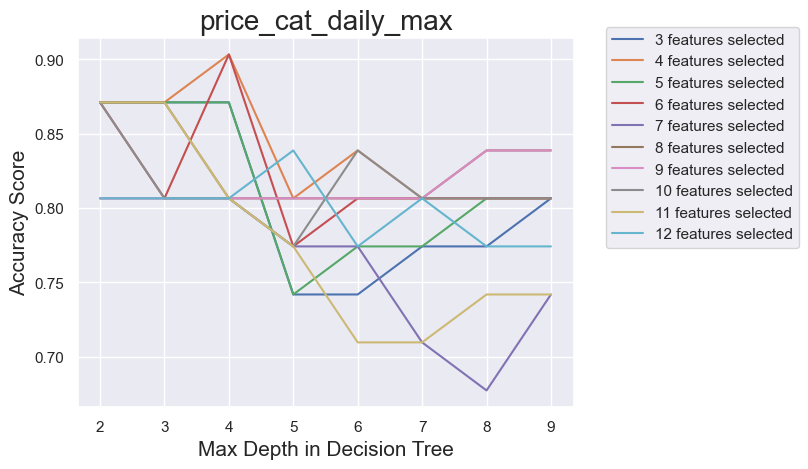

In [204]:
#missing values dropped to apply feature selection
data = merged_data_daily.dropna()
data = data.reset_index().drop(["index"], axis=1)

demand = ["demand_max_cat_average"]
price_category = ["price_cat_daily_max"]

for i in range(len(demand)):
    #feature_selection
    for no_fea_selec in range(3, 13):
        accuracy_list = []
        depth_list = []
        #max_depth selection
        for dt_depth in range(2,10):
            features = ["min_temp", "rainfall", "evaporation", "9am_rela_humi", "9am_cloud", "9am_wind_dir_n",
                        "3pm_rela_humi", "3pm_cloud", "3pm_wind_speed", "3pm_msl_press", "month", "weekday"]
            features.append(demand[i])
    
            x = data[features]
            y = data[price_category[i]]

            x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42) 
            
            # Instantiate
            feature_selector = SelectKBest(chi2, k=no_fea_selec)
            # Perform selection
            x_train = feature_selector.fit_transform(x_train, y_train)
            x_test = feature_selector.transform(x_test) 
            
            scaler = StandardScaler().fit(x_train)
            x_train = scaler.transform(x_train)
            x_test = scaler.transform(x_test) 

            imputer = SimpleImputer(strategy='mean')
            x_train = imputer.fit_transform(x_train)
            x_test = imputer.transform(x_test)  
            
            dt = DecisionTreeClassifier(criterion="entropy", random_state=42, max_depth=dt_depth)
            dt.fit(x_train, y_train)

            y_pred = dt.predict(x_test)

            classification_accuracy = accuracy_score(y_test, y_pred)
            accuracy_list.append(round(classification_accuracy,4))
            depth_list.append(dt_depth)
            
        plt.plot(depth_list, accuracy_list, label = (f"{no_fea_selec} features selected"))
    
        print(no_fea_selec, "Features Accuracy Score:", accuracy_list)
        
        plt.legend(bbox_to_anchor=(1.05, 1.05), prop={'size':11})
    plt.title(price_category[i], fontsize=20)
    plt.xlabel("Max Depth in Decision Tree", fontsize=15)
    plt.ylabel("Accuracy Score", fontsize=15)
    plt.show()

#### To see the selected features

In [205]:
#missing values dropped to apply feature selection
data = merged_data_daily.dropna()
data = data.reset_index().drop(["index"], axis=1)

demand = ["demand_max_cat_average"] #uncomment to analyze daily_max only
price_category = ["price_cat_daily_max"] #uncomment to analyze daily_max only
#demand = ["demand_daily_average", "demand_max_cat_average", "demand_mode_cat_average"]
#price_category = ["price_cat_daily_average", "price_cat_daily_max", "price_cat_daily_mode"]

for i in range(len(demand)):
    #feature_selection
    for no_fea_selec in range(6, 7):
        accuracy_list = []
        depth_list = []
        #max_depth selection
        for dt_depth in range(4,5):
            features = ["min_temp", "rainfall", "evaporation", "9am_rela_humi", "9am_cloud", "9am_wind_dir_n",
                        "3pm_rela_humi", "3pm_cloud", "3pm_wind_speed", "3pm_msl_press", "month", "weekday"]
            features.append(demand[i])
    
            x = data[features]
            y = data[price_category[i]]

            x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

            # Instantiate
            feature_selector = SelectKBest(chi2, k=no_fea_selec)
            # Perform selection
            x_train = feature_selector.fit_transform(x_train, y_train)
            x_test = feature_selector.transform(x_test)    
            
            scaler = StandardScaler().fit(x_train)
            x_train = scaler.transform(x_train)
            x_test = scaler.transform(x_test)
            
            imputer = SimpleImputer(strategy='mean')
            x_train = imputer.fit_transform(x_train)
            x_test = imputer.transform(x_test)    

            dt = DecisionTreeClassifier(criterion="entropy", random_state=42, max_depth=dt_depth)
            dt.fit(x_train, y_train)

            y_pred = dt.predict(x_test)

            classification_accuracy = accuracy_score(y_test, y_pred)
            accuracy_list.append(round(classification_accuracy,4))
            depth_list.append(dt_depth)
            
        print(no_fea_selec, "Features at Max_depth of", dt_depth, "Accuracy Score:", accuracy_list)

feature_selector.get_support(1)
mask = feature_selector.get_support()
new_features = []
for bool, select_feature in zip(mask, features):
    if bool:
        new_features.append(select_feature)
print(new_features)

6 Features at Max_depth of 4 Accuracy Score: [0.9032]
['rainfall', 'evaporation', '9am_rela_humi', '3pm_wind_speed', 'weekday', 'demand_max_cat_average']


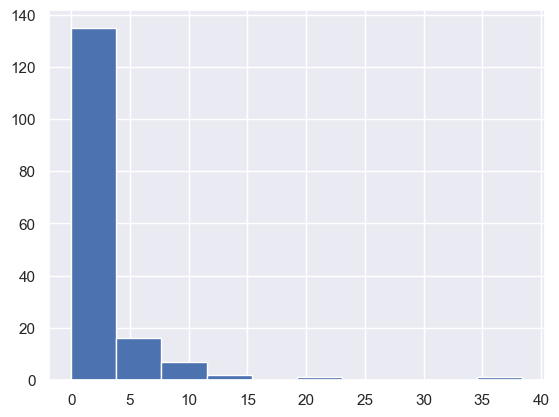

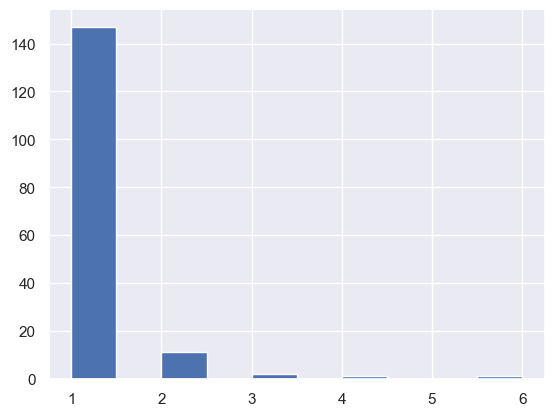

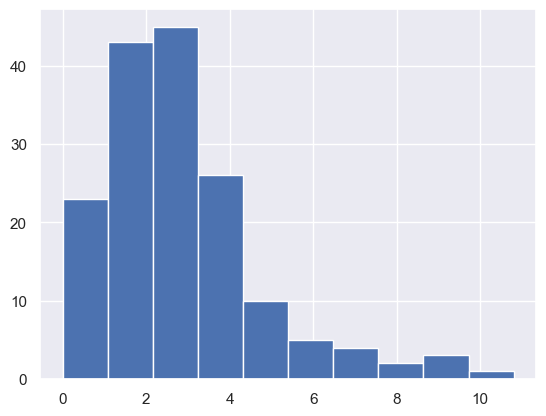

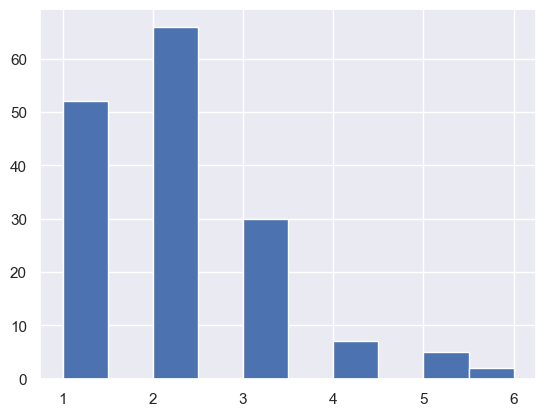

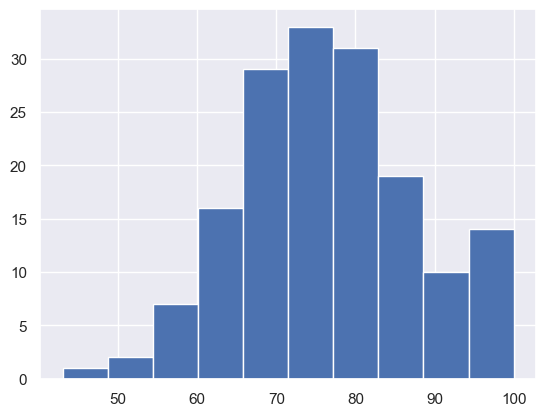

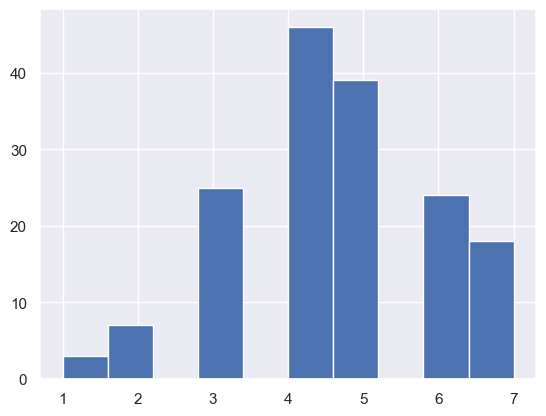

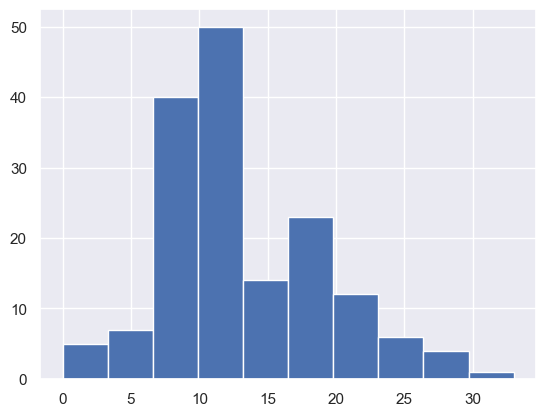

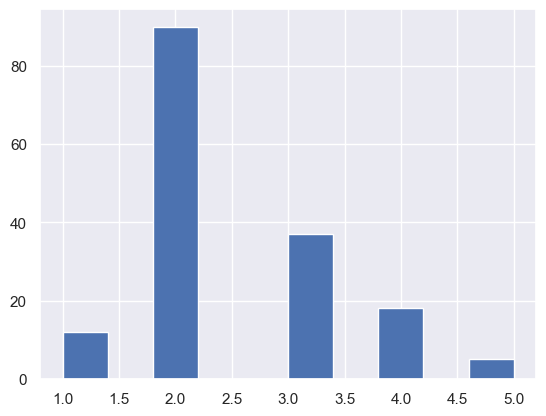

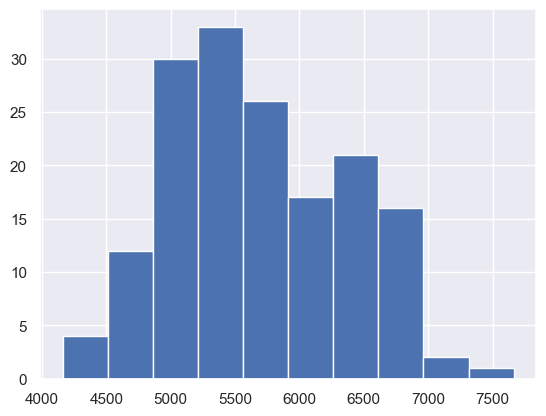

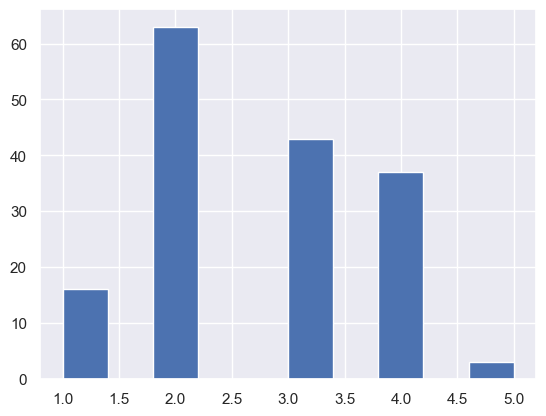

In [206]:
# Checking the inter-correlation between variables
# Bin numerical variables

# 1. rainfall
merged_data_daily['rainfall'].hist()
plt.show()
# bin the numerical column into 5 groups
merged_data_daily['rainfall_bin'] = pd.cut(merged_data_daily['rainfall'], bins=6, labels=[1,2,3,4,5,6])
# print the new DataFrame with the binned column
merged_data_daily['rainfall_bin'].hist()
plt.show()

# 2. rainfall
merged_data_daily['evaporation'].hist()
plt.show()
# bin the numerical column into 6 groups
merged_data_daily['evaporation_bin'] = pd.cut(merged_data_daily['evaporation'], bins=6, labels=[1,2,3,4,5,6])
# print the new DataFrame with the binned column
merged_data_daily['evaporation_bin'].hist()
plt.show()

# 3. 9am_rela_humi
merged_data_daily['9am_rela_humi'].hist()
plt.show()
# bin the numerical column into 7 groups
merged_data_daily['9am_rela_humi_bin'] = pd.cut(merged_data_daily['9am_rela_humi'], bins=7, labels=[1,2,3,4,5,6,7])
# print the new DataFrame with the binned column
merged_data_daily['9am_rela_humi_bin'].hist()
plt.show()

# 4. 3pm_wind_speed
merged_data_daily['3pm_wind_speed'].hist()
plt.show()
# bin the numerical column into 5 groups
merged_data_daily['3pm_wind_speed_bin'] = pd.cut(merged_data_daily['3pm_wind_speed'], bins=5, labels=[1,2,3,4,5])
# print the new DataFrame with the binned column
merged_data_daily['3pm_wind_speed_bin'].hist()
plt.show()

# 5. demand_max_cat_average
merged_data_daily['demand_max_cat_average'].hist()
plt.show()
# bin the numerical column into 5 groups
merged_data_daily['demand_max_cat_average_bin'] = pd.cut(merged_data_daily['demand_max_cat_average'], bins=5, labels=[1,2,3,4,5])
# print the new DataFrame with the binned column
merged_data_daily['demand_max_cat_average_bin'].hist()
plt.show()

Text(0.5, 1.0, 'NMI between Categorical Variables')

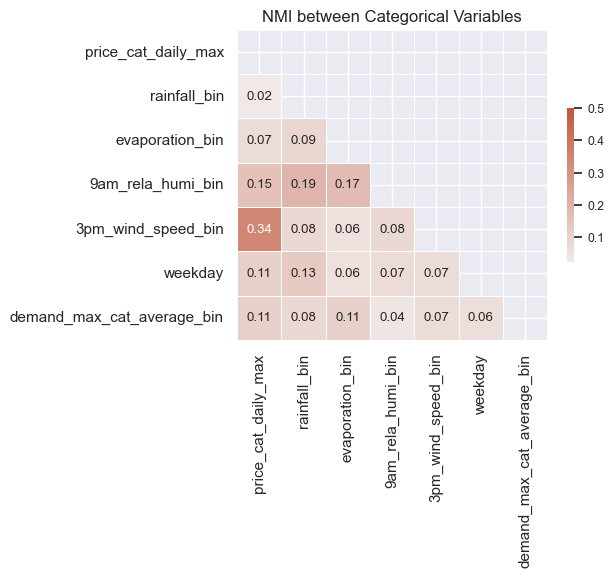

In [208]:
#Analysing NMI between categorical variables
#NMI => [0, 1]
# < 0.2: non-existent
# 0.2 - 0.4: moderate
# 0.5 - 0.7: strong
# 0.8 - 1.0: very strong

categorical_variables = ["price_cat_daily_max", 'rainfall_bin', 'evaporation_bin', '9am_rela_humi_bin', '3pm_wind_speed_bin', 
                         'weekday', 'demand_max_cat_average_bin']

nmi_matrix = {}

for cat_1 in categorical_variables:
    nmi_row = []
    for cat_2 in categorical_variables:
        temp_data = merged_data_daily.dropna(subset=[cat_1])
        temp_data = temp_data.dropna(subset=[cat_2])
        NMI = normalized_mutual_info_score(temp_data[cat_1], temp_data[cat_2], average_method='min')
        nmi_row.append(NMI)
    nmi_matrix[cat_1] = nmi_row

nmi_df = pd.DataFrame(data = nmi_matrix,columns=categorical_variables, index=categorical_variables)

mask = np.triu(np.ones_like(nmi_df, dtype=bool))
f, ax = plt.subplots(figsize=(5, 10))
cmap = sb.diverging_palette(50, 20, as_cmap=True)
sb.set(font_scale=0.8)
ax = sb.heatmap(nmi_df, annot = True, mask=mask, cmap=cmap, vmax=.5, center=0,
           fmt=".2f", square=True, linewidths=.5, cbar_kws={"shrink": .2})
plt.title("NMI between Categorical Variables", fontsize=12)

Length of features list: 6


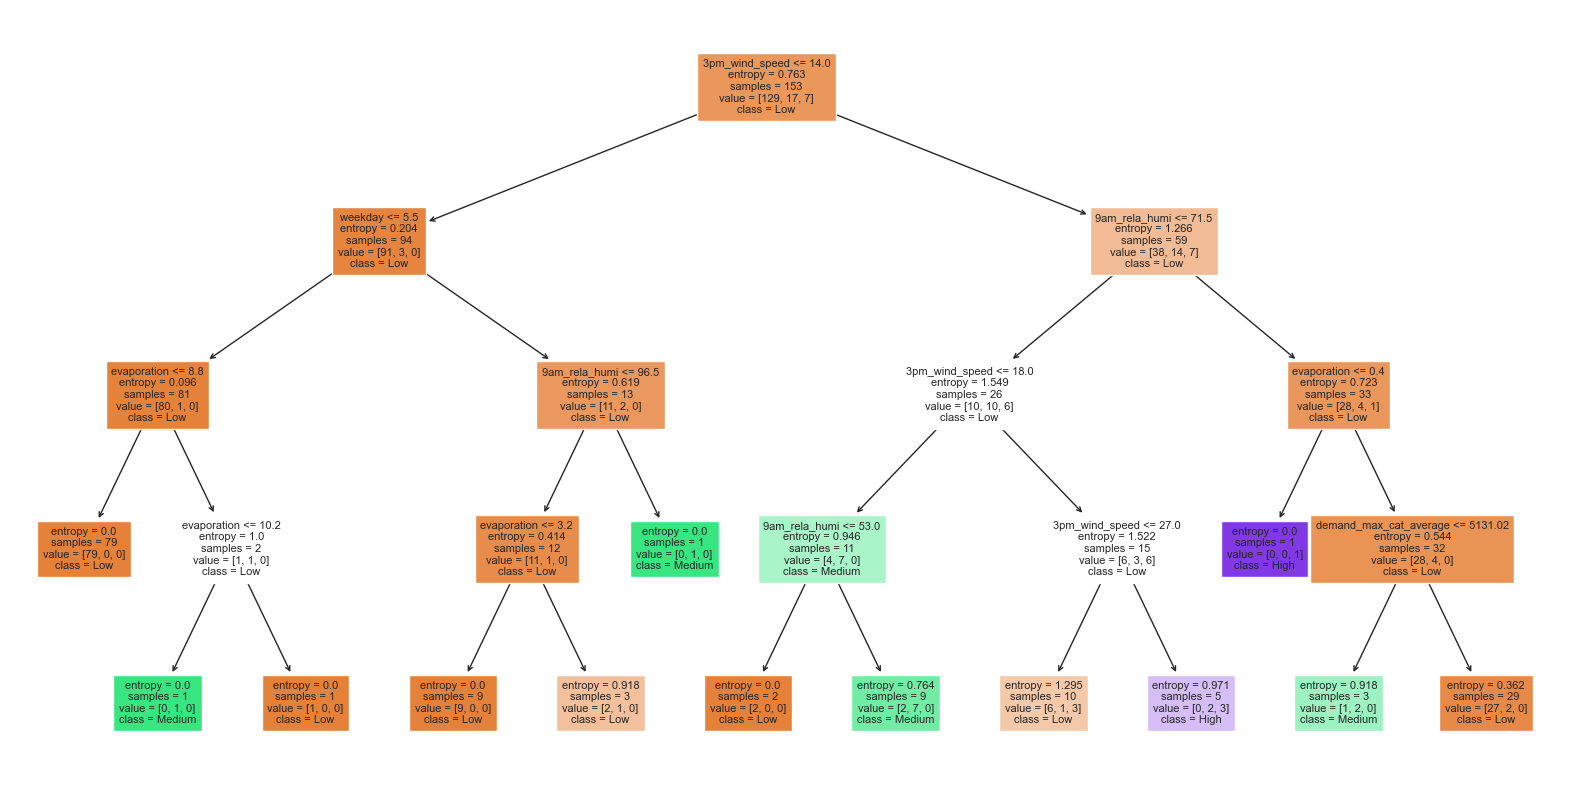

In [211]:
# Visualising the Decision Trees

features_base = ['rainfall', 'evaporation', '9am_rela_humi', '3pm_wind_speed', 
                 'weekday', 'demand_max_cat_average']

price_category = ["price_cat_daily_max"]

for i in range(len(price_category)):
    features = features_base.copy()
    print("Length of features list:", len(features))

    x = data[features]
    y = data[price_category[i]]

    dt = DecisionTreeClassifier(criterion="entropy", random_state=42, max_depth=4)
    dt.fit(x, y)

    plt.figure(figsize=(20, 10))
    plot_tree(dt, feature_names=features, class_names=['Low', 'Medium', 'High', 'Extreme'], filled=True, fontsize=8)
    plt.show()

### K-Fold for Decision Tree


In [212]:
data = merged_data_daily.reset_index().drop(["index"], axis=1)

price_category = ["price_cat_daily_max"]

for i in range(len(price_category)):
    features = ['rainfall', 'evaporation', '9am_rela_humi', '3pm_wind_speed', 'weekday', 'demand_max_cat_average']
    
    x = data[features]
    y = data[price_category[i]]
    
    k = 10
    kf = KFold(n_splits=k, shuffle=True, random_state=42)
    accuracy_scores=[]
        
    for train_index, test_index in kf.split(data):    
        x_train = x.iloc[train_index, :]
        x_test = x.iloc[test_index, :]
            
        y_train = y[train_index]
        y_test = y[test_index]
            
        scaler = StandardScaler().fit(x_train)
        x_train = scaler.transform(x_train)
        x_test = scaler.transform(x_test)
            
        imputer = SimpleImputer(strategy='mean')
        x_train = imputer.fit_transform(x_train)
        x_test = imputer.fit_transform(x_test)
            
        dt = DecisionTreeClassifier(criterion="entropy", random_state=42, max_depth=4)
        dt.fit(x_train, y_train)
        
        y_pred = dt.predict(x_test)
        
        accuracy_scores.append(round(accuracy_score(y_test, y_pred),4))   

    print("K-Fold with K=10 for Decision Tree with 6 Selected Features:")
    print("")
    print("Decision Tree Accuracy Average:", sum(accuracy_scores)/len(accuracy_scores))
    print(f"Decision Tree Accuracy List: {accuracy_scores}")
    print("***********************************************************************")
    print(" ")

K-Fold with K=10 for Decision Tree with 6 Selected Features:

Decision Tree Accuracy Average: 0.82757
Decision Tree Accuracy List: [0.7647, 0.8235, 0.9375, 0.8125, 0.9375, 0.875, 0.875, 0.875, 0.625, 0.75]
***********************************************************************
 


# KNN Model

In [217]:
data = merged_data_daily.reset_index().drop(["index"], axis=1)

demand = ["demand_max_cat_average"]
price_category = ["price_cat_daily_max"]

for i in range(len(demand)):
    features = ["min_temp", "rainfall", "evaporation", "9am_rela_humi", "9am_cloud", "9am_wind_dir_n",
                "3pm_rela_humi", "3pm_cloud", "3pm_wind_speed", "3pm_msl_press", "month", "weekday"]
    features.append(demand[i])
    
    x = data[features]
    y = data[price_category[i]]

    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=5)

    scaler = StandardScaler().fit(x_train)
    x_train = scaler.transform(x_train)
    x_test = scaler.transform(x_test)
    
    imputer = SimpleImputer(strategy='mean')
    x_train = imputer.fit_transform(x_train)
    x_test = imputer.fit_transform(x_test)

    knn = neighbors.KNeighborsClassifier(n_neighbors=5)
    knn.fit(x_train, y_train)

    y_pred = knn.predict(x_test)

    classification_accuracy = accuracy_score(y_test, y_pred)
    print(price_category[i])
    print("KNN Accuracy:", classification_accuracy)
    print("KNN Report:")
    print(classification_report(y_test, y_pred, zero_division=1))
    print("**********************************************************")
    print(" ")

price_cat_daily_max
KNN Accuracy: 0.8484848484848485
KNN Report:
              precision    recall  f1-score   support

     EXTREME       0.85      1.00      0.92        28
        HIGH       1.00      0.00      0.00         3
      MEDIUM       1.00      0.00      0.00         2

    accuracy                           0.85        33
   macro avg       0.95      0.33      0.31        33
weighted avg       0.87      0.85      0.78        33

**********************************************************
 


## Feature Selection

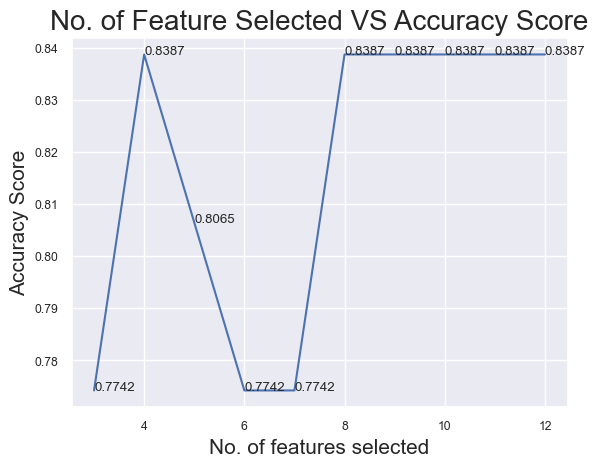

In [215]:
data = merged_data_daily.dropna()
data = data.reset_index().drop(["index"], axis=1)

demand = ["demand_max_cat_average"]
price_category = ["price_cat_daily_max"]

for i in range(len(demand)):
    accuracy_list=[]
    fea_list=[]
    for no_fea_selec in range(3, 13):
        features = ["min_temp", "rainfall", "evaporation", "9am_rela_humi", "9am_cloud", "9am_wind_dir_n",
                    "3pm_rela_humi", "3pm_cloud", "3pm_wind_speed", "3pm_msl_press", "month", "weekday"]
        features.append(demand[i])
    
        x = data[features]
        y = data[price_category[i]]

        x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=5)

        # Instantiate
        feature_selector = SelectKBest(chi2, k=no_fea_selec)
        # Perform selection
        x_train = feature_selector.fit_transform(x_train, y_train)
        x_test = feature_selector.transform(x_test)            
        
        scaler = StandardScaler().fit(x_train)
        x_train = scaler.transform(x_train)
        x_test = scaler.transform(x_test)
    
        mputer = SimpleImputer(strategy='mean')
        x_train = imputer.fit_transform(x_train)
        x_test = imputer.fit_transform(x_test)

        knn = neighbors.KNeighborsClassifier(n_neighbors=5)
        knn.fit(x_train, y_train)

        y_pred = knn.predict(x_test)

        classification_accuracy = accuracy_score(y_test, y_pred)

        accuracy_list.append(classification_accuracy)
        fea_list.append(no_fea_selec)
    
    plt.plot(fea_list, accuracy_list)
    plt.title("No. of Feature Selected VS Accuracy Score", fontsize = 20)
    plt.xlabel("No. of features selected", fontsize = 15)
    plt.ylabel("Accuracy Score", fontsize = 15)
    for a,b in zip(fea_list, accuracy_list): 
        plt.text(a, b, str(round(b,4)))
    plt.rcParams.update({'font.size': 10})
    plt.show()

In [218]:
data = merged_data_daily.dropna()
data = data.reset_index().drop(["index"], axis=1)

demand = ["demand_max_cat_average"]
price_category = ["price_cat_daily_max"]

for i in range(len(demand)):
    accuracy_list=[]
    fea_list=[]
    for no_fea_selec in range(8, 9):
        features = ["min_temp", "rainfall", "evaporation", "9am_rela_humi", "9am_cloud", "9am_wind_dir_n",
                    "3pm_rela_humi", "3pm_cloud", "3pm_wind_speed", "3pm_msl_press", "month", "weekday"]
        features.append(demand[i])
    
        x = data[features]
        y = data[price_category[i]]

        x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=5)

        # Instantiate
        feature_selector = SelectKBest(chi2, k=no_fea_selec)
        # Perform selection
        x_train = feature_selector.fit_transform(x_train, y_train)
        x_test = feature_selector.transform(x_test)            
        
        scaler = StandardScaler().fit(x_train)
        x_train = scaler.transform(x_train)
        x_test = scaler.transform(x_test)
    
        mputer = SimpleImputer(strategy='mean')
        x_train = imputer.fit_transform(x_train)
        x_test = imputer.fit_transform(x_test)

        knn = neighbors.KNeighborsClassifier(n_neighbors=5)
        knn.fit(x_train, y_train)

        y_pred = knn.predict(x_test)

        classification_accuracy = accuracy_score(y_test, y_pred)

        accuracy_list.append(classification_accuracy)
        fea_list.append(no_fea_selec)
    
        print(no_fea_selec, "Features selected Accuracy Score:", accuracy_list)

feature_selector.get_support(1)
mask = feature_selector.get_support()
new_features = []
for bool, select_feature in zip(mask, features):
    if bool:
        new_features.append(select_feature)
print(new_features)

8 Features selected Accuracy Score: [0.8387096774193549]
['min_temp', 'evaporation', '9am_rela_humi', '9am_wind_dir_n', '3pm_cloud', '3pm_wind_speed', 'weekday', 'demand_max_cat_average']


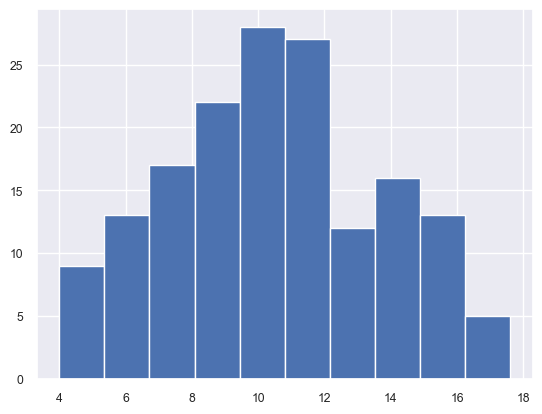

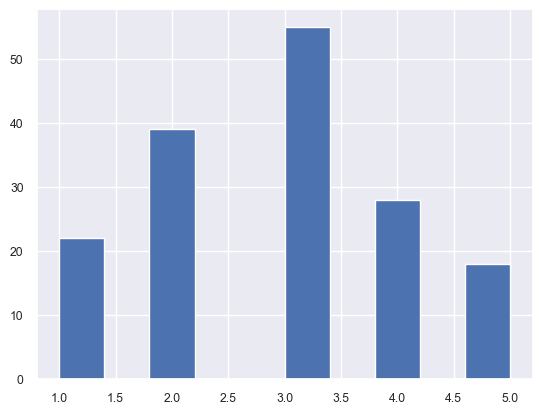

In [219]:
# To examine the inter-correlation between features selected

# Bin min_temp
merged_data_daily['min_temp'].hist()
plt.show()
# bin the numerical column into 5 groups
merged_data_daily['min_temp_bin'] = pd.cut(merged_data_daily['min_temp'], bins=5, labels=[1,2,3,4,5])
# print the new DataFrame with the binned column
merged_data_daily['min_temp_bin'].hist()
plt.show()

Text(0.5, 1.0, 'NMI between Categorical Variables')

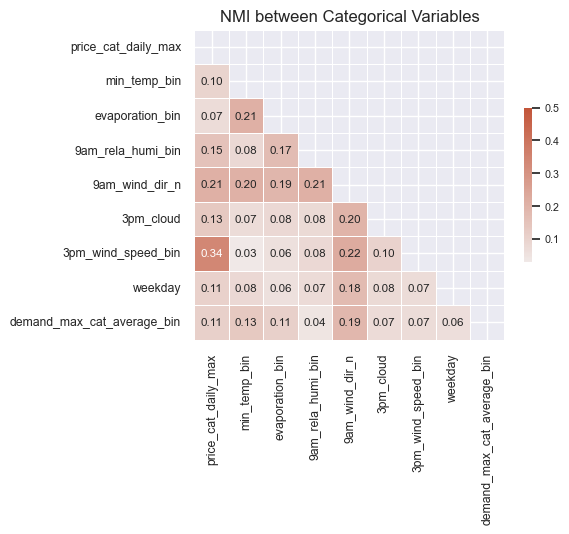

In [220]:
#Analysing NMI between categorical variables
#NMI => [0, 1]
# < 0.2: non-existent
# 0.2 - 0.4: moderate
# 0.5 - 0.7: strong
# 0.8 - 1.0: very strong

categorical_variables = ["price_cat_daily_max", 'min_temp_bin', 'evaporation_bin', '9am_rela_humi_bin', '9am_wind_dir_n', 
                         '3pm_cloud', '3pm_wind_speed_bin', 'weekday', 'demand_max_cat_average_bin']

nmi_matrix = {}

for cat_1 in categorical_variables:
    nmi_row = []
    for cat_2 in categorical_variables:
        temp_data = merged_data_daily.dropna(subset=[cat_1])
        temp_data = temp_data.dropna(subset=[cat_2])
        NMI = normalized_mutual_info_score(temp_data[cat_1], temp_data[cat_2], average_method='min')
        nmi_row.append(NMI)
    nmi_matrix[cat_1] = nmi_row

nmi_df = pd.DataFrame(data = nmi_matrix,columns=categorical_variables, index=categorical_variables)

mask = np.triu(np.ones_like(nmi_df, dtype=bool))
f, ax = plt.subplots(figsize=(5, 10))
cmap = sb.diverging_palette(50, 20, as_cmap=True)
sb.set(font_scale=0.7)
ax = sb.heatmap(nmi_df, annot = True, mask=mask, cmap=cmap, vmax=.5, center=0,
           fmt=".2f", square=True, linewidths=.5, cbar_kws={"shrink": .2})
plt.title("NMI between Categorical Variables", fontsize=12)

### K-fold for KNN

In [221]:
data = merged_data_daily.reset_index().drop(["index"], axis=1)

price_category = ["price_cat_daily_max"]
for i in range(len(demand)):
    features = ["min_temp", "rainfall", "evaporation", "9am_rela_humi", "9am_cloud", "9am_wind_dir_n",
                "3pm_rela_humi", "3pm_cloud", "3pm_wind_speed", "3pm_msl_press", "month", "weekday"]
    
    x = data[features]
    y = data[price_category[i]]
    
    k = 10
    kf = KFold(n_splits=k, shuffle=True, random_state=42)
    neighbour_accuracy=[]

    for neighbours in range(1,k):
        accuracy_scores=[]
        for train_index, test_index in kf.split(data):    
            x_train = x.iloc[train_index, :]
            x_test = x.iloc[test_index, :]
            
            y_train = y[train_index]
            y_test = y[test_index]
            
            scaler = StandardScaler().fit(x_train)
            x_train = scaler.transform(x_train)
            x_test = scaler.transform(x_test)
            
            imputer = SimpleImputer(strategy='mean')
            x_train = imputer.fit_transform(x_train)    
            x_test = imputer.fit_transform(x_test)    
                
            knn = neighbors.KNeighborsClassifier(n_neighbors=neighbours)
            knn.fit(x_train, y_train)
        
            y_pred = knn.predict(x_test)
        
            accuracy_scores.append(accuracy_score(y_test, y_pred))

        neighbour_accuracy.append(round(sum(accuracy_scores)/k,2))
    
    print("K-Fold with K=10 for KNN model with 8 features")
    print("")
    print("KNN Accuracy Average:", sum(neighbour_accuracy)/len(neighbour_accuracy))
    print(f"KNN Accuracy List for Different Neighbours: {neighbour_accuracy}")
    print("***********************************************************************")
    print(" ")

K-Fold with K=10 for KNN model with 8 features

KNN Accuracy Average: 0.8355555555555554
KNN Accuracy List for Different Neighbours: [0.81, 0.84, 0.82, 0.83, 0.83, 0.85, 0.84, 0.85, 0.85]
***********************************************************************
 


# Visualisation